In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.text as text
import math

Stim shape:  (2878, 3)
Response shape:  (639, 2878)
Frames:  2878
Neurons:  639
Number of stim:  20


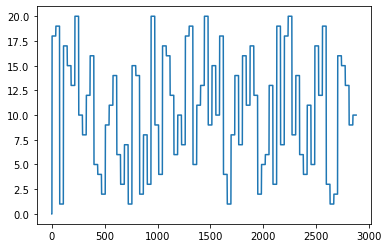

In [5]:
# Import data

# stim - data on which stimulus was on for each frame
stim = np.loadtxt("./data/stim_data.txt") 
# ests - raw Ca++ imaginig data
ests = np.loadtxt("./data/raw_C.txt")

print("Stim shape: ", stim.shape)
print("Response shape: ",ests.shape)

num_frames = stim.shape[0]
num_neurons = ests.shape[0]

print("Frames: ", num_frames)
print("Neurons: ", num_neurons)

stim = stim.astype(int)

num_stim = np.max(stim[:,0])
print("Number of stim: ", num_stim)

# Double checking that each stim has 4 "on" windows
fig, ax = plt.subplots()
plt.plot(stim[:,0])


In [6]:
# Create windows where each stim is on

stimStart = {} # key: stim, value: list of frames stim was turned on
stimEnd = {} # key: stim, value: list of frames stim was turned off

framesStimOn = [] # frames when a stim was turned on
framesStimOff = [] # frames when a stim was turned off


num_on_windows = 0 # number of windows (during which any stim was on or no stim were on)
num_off_windows = 0 # number of windows no stim was on
for s in range(0,num_stim+1):
    stimStart[s] = []
    stimEnd[s] = []

# For each stim, construct array of indices when frame was turned on (start) and off (end)
# Also construct similar array for start and start of "off" windows, i.e. no stim on
lastOn = False
lastOff = True
for f in range(num_frames):
    curr_stim = stim[f,0] 
    if ((stim[f, 1] < -18 or stim[f,1] > 18)): 
        if (lastOff): # Stim was just turned on this frame
            num_on_windows += 1 # Increment number of windows
            framesStimOn.append(f) # Add this datapoint to list of frames when a stim was turned on
            stimStart[curr_stim].append(f)
            stimEnd[0].append(f) # off window just ended
            num_off_windows += 1 # Incremement number of off windows (since we set them based on ends)
            lastOn = True
            lastOff = False

    elif (stim[f, 1] == 0):
        if (lastOn): # Stim was just turned off this frame
            stimEnd[curr_stim].append(f)
            framesStimOff.append(f)
            stimStart[0].append(f) # off window just started
            lastOn = False
            lastOff = True

# total windows
num_windows = num_on_windows + num_off_windows

windowStim = {} # key: window ID, value: stim on in window with that window ID (**not chronological)

curr_window = 0
for s in range(0, num_stim+1):
    for w in range(len(stimStart[s])):
        start = stimStart[s][w]
        try:
            end = stimEnd[s][w]
        except IndexError: # more "end" values than "start" values; "end" must be the last frame in the dataset
            end = num_frames
        windowStim[curr_window] = s
        curr_window += 1
        
framesStimOn = np.array(framesStimOn)
framesStimOff = np.array(framesStimOff)

print("Created {} windows where a stimulus was on".format(num_on_windows))
print("Created {} windows where all stimulus were off".format(num_off_windows))

Created 80 windows where a stimulus was on
Created 80 windows where all stimulus were off


In [7]:
stimWindowAvg = np.zeros((num_neurons, num_windows + 1)) # rows: neurons, cols: avgs for window with id = col index

""" 
key: neuron, value: dictionary -> 
   (key: stim, value: avgs for that stim for this neuron)
""" 
estsByStim = {} 
for n in range(num_neurons):
    estsByStim[n] = {}
    for stimId in range(0,num_stim+1):
        estsByStim[n][stimId] = []

"""
Loop over each stim and its corresponding "on" windows 
(not in chronological order of windows)
""" 
windowId = 0
for stimId in range(0,num_stim+1): # Loop over all stim (which have id 0-20 when including off windows)
    if (stimId == 0):
        for end in stimEnd[stimId]:
            onInd = np.arange(end-10,end-1) # Hard code stim off offset
            onInd = onInd[onInd<num_frames]
            onEst = np.mean(ests[:,onInd], axis=1)
            for neuron in range(onEst.shape[0]):
                estsByStim[neuron][stimId].append(onEst[neuron])
            windowId += 1

    else: # actual stim on windows
        for start in stimStart[stimId]:
            onInd = np.arange(start+5,start+15) # Hard code start offset as 5 frames
            onInd = onInd[onInd<num_frames]
            onEst = np.mean(ests[:,onInd], axis=1)
            stimWindowAvg[:,windowId] = onEst  
            for neuron in range(onEst.shape[0]):
                estsByStim[neuron][stimId].append(onEst[neuron])
            windowId += 1

print("Mean responses of neuron 0 to stim 1 windows:\n\n", estsByStim[0][1])

Mean responses of neuron 0 to stim 1 windows:

 [12.495549392700195, 3.8252284049987795, 5.592079114913941, 2.1941470742225646]


In [8]:
def getStimType(stimId):
 
    eyes = ["both",
         "both",
         "both",
         "both",
         "left", 
         "left", 
         "right",
         "right",
         "both",
         "both",
         "left",
         "both",
         "both",
         "both",
         "right",
         "both",
         "right",
         "left",
         "both",
         "both",]
        
    types = ["inward",
         "outward",
         "rightward",
         "leftward",
         "medial", 
         "lateral", 
         "medial",
         "lateral",
         "forward",
         "forward right",
         "forward",
         "back right",
         "backward",
         "back left",
         "forward",
         "forward left",
         "backward",
         "backward",
         "left forward, right backward",
         "left backward,right forward"]
    
    # each element is a tuple of left eye angle, right eye angle
    # angles are in degrees
    # negative angle means that eye is not presented a stimulus
    angles = [[0,180],
             [180,0],
             [0,0],
             [180,180],
             [0, -1],
             [180,-1],
             [-1,180],
             [-1,0],
             [90,90],
             [45,45],
             [90,-1],
             [315,315],
             [270,270],
             [225,225],
             [-1,90],
             [135,135],
             [-1,270],
             [270,-1],
             [90,270],
             [270,90]]

    return {"eye": eyes[stimId-1], 
            "type": types[stimId-1], 
            "leftAngle": angles[stimId-1][0],
            "rightAngle": angles[stimId-1][1]}

### Plot 1: Histograms of mean response of each neuron  to each stim
---
- **x-axis:** Mean response over a window corresponding to that stimulus, taking into account the hard-coded (5 frame) offset
- **y-axis:** Frequncy of that mean response (i.e. how many windows this neuron responded in that way to this stimulus)

**Description**

- The following plots show the distribution of each neuron's mean responses to a given stimulus. Each datapoint on each graph is one window corresponding to the graph subplot title stimulus. Currently 4 datapoints per stim for a given neuron because each stim was turned on a total of 4 times in the dataset analyzed here. 

- Plots are grouped by eyes a stimulus was presented to: purple = left, green = right, and black = both (can be conflicting or non-conflicting). 

**Takeaways**
- Plots with more than just 4 datapoints around 0 indicate the neuron is at least partially tuned toward the stimulus of that plot.
- These plots are useful to cross check against the following polar plots, distributions, and raw trace plots to identify which stim a neuron is tuned toward.

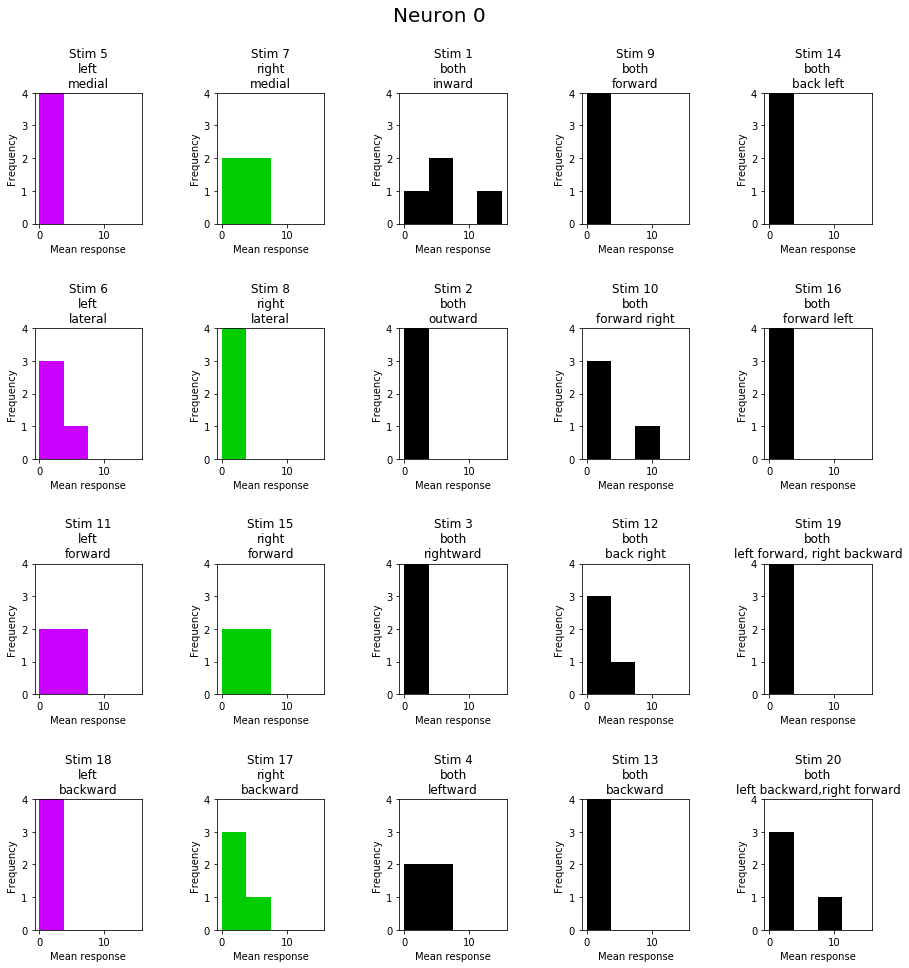

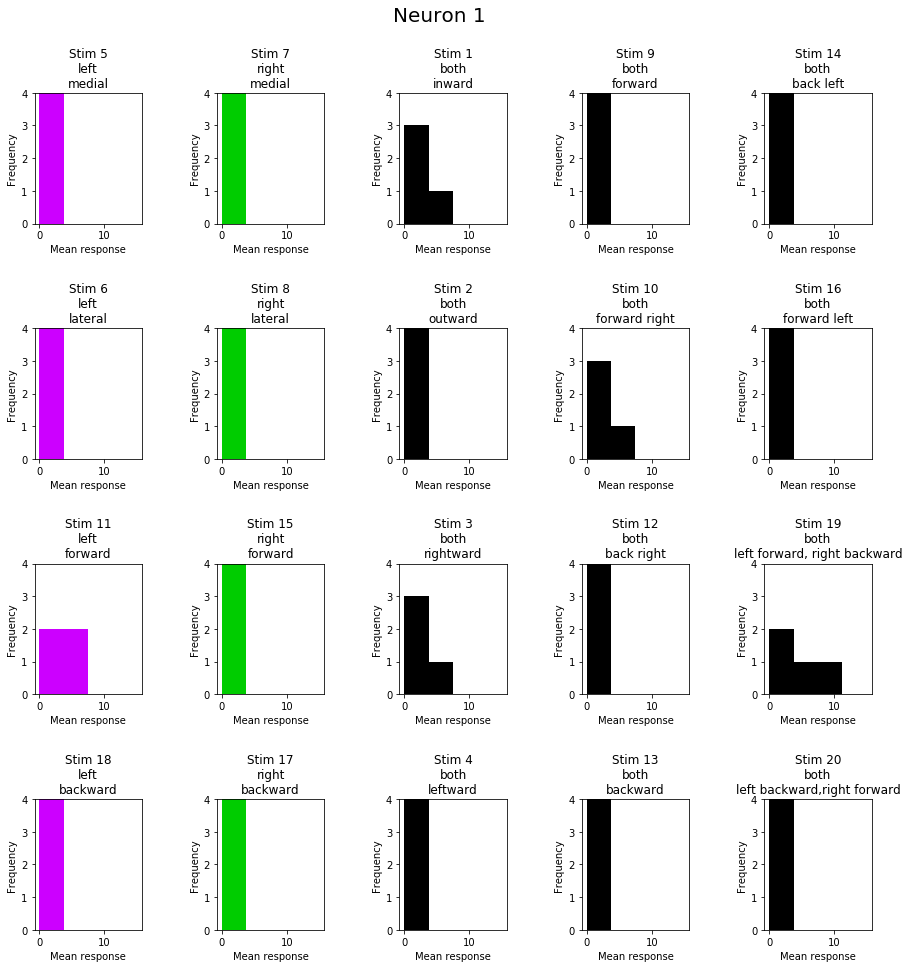

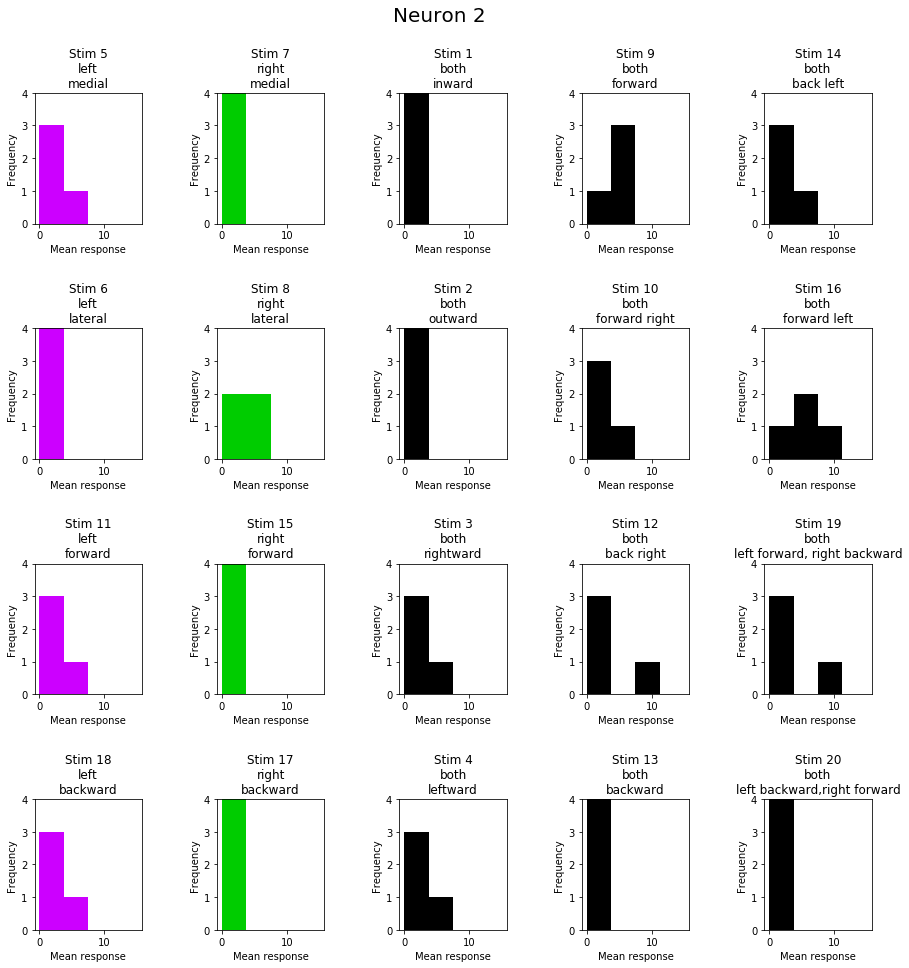

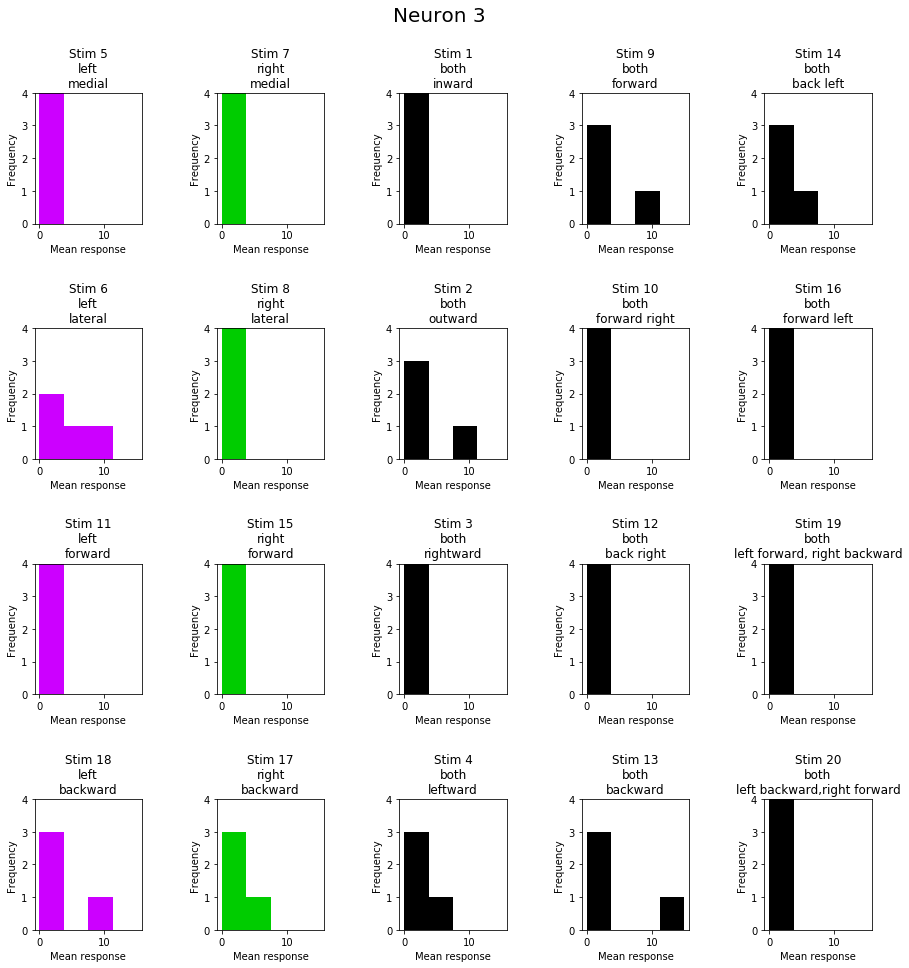

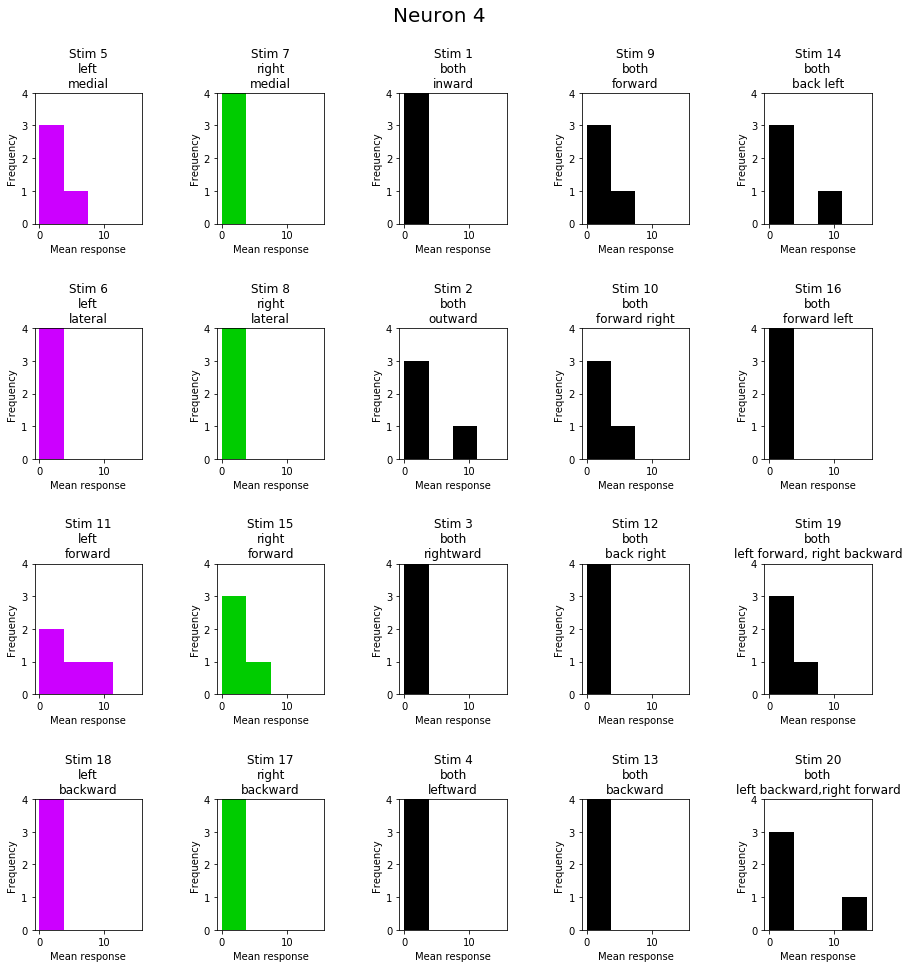

In [9]:
%matplotlib inline

# Plot histograms of response of each neuron to each stim
# Response is the mean response of that neuron over the interval corresponding to that stim

# Assign left, right, and both eye stimuli to their own columns in the subplot
def columnByEye(eye):
    column = 2
    if (eye == "left"):
        column = 0
    elif (eye == "right"):
        column = 1
    return column

# Assign colors of bars by stimulus eye type
def colorByEye(eye):
    color = "black"
    if (eye == "left"):
        color = "#cc00ff"
    elif (eye == "right"):
        color = "#00cc00"
    return color
for n in range(5): # See first 5 neurons
    fig, ax = plt.subplots(4,5,figsize=(15,15))
    fig.suptitle("Neuron {}".format(n), fontsize=20)


    for eyeType in ["left", "right", "both"]: 
        plotNum = 0
        for stimId in range(1,num_stim+1):
            stimType = getStimType(stimId)
            
            eye = stimType["eye"]
            if (eye != eyeType):
                continue
            else:
                responses = np.array(estsByStim[n][stimId])
                 
                i = plotNum
                j = columnByEye(stimType["eye"])
                
                if j == 2:
                    i = plotNum % 4
                    j = j + math.floor(plotNum / 4)
                ax[i,j].hist(responses,bins=4, range=(0, 15), color=colorByEye(eye))
                ax[i,j].set_title("Stim {}\n{}\n{}".format(stimId, eye, stimType["type"]))
                ax[i,j].set_ylim([0,4])
                ax[i,j].set_xlabel("Mean response")
                ax[i,j].set_ylabel("Frequency")
                plotNum += 1
    plt.subplots_adjust(top=0.9,wspace=0.7,hspace=0.8)
    

### Plot 2: Polar plots of mean response of each neuron to each stim direction, by eye
---
- $\bf{r}$: Mean response over a window corresponding to the stimulus, taking into account the hard-coded (5 frame) offset
- $\bf{\theta}$: Angle that the stimulus presents to the specified eye, where $0^{\circ}$ is right and $180^{\circ}$ is left.

**Description**

- Polar plots for each eye of each neuron
- These plots currrently take into consideration all kinds of stim, but only the way each stim presents to the specified eye. For example, for "inward" stimuli, the left eye takes the response to this stim as $r$ and plots it with $\theta = 0^{\circ}$, while the right eye takes the same value of $r$ but plots it with $\theta = 180^{\circ}$.

**Takeaways**
- Larger r indicate greater tuning toward a stimulus. Neurons that are highly tuned will have plots with lots of very small values of r and a large peak of r at the angle to which they are tuned.

In [10]:
%matplotlib inline

# Plot polar tuning curves of each neuron

# eye = "left" or "right"
def makePolarPlot(neuron, eye):
    responses = estsByStim[neuron]
    r = np.zeros(int(360/45) + 1)
    rDict = {}
    theta = np.append(np.arange(0,360,step=45),0)
    
    for t in range(0,360+45,45):
        rDict[t] = []
    
    for s in range(1, num_stim + 1):
        stimType = getStimType(s)
        angle = stimType[eye + "Angle"]
        eyeType = stimType["eye"]
        if (angle < 0):
            continue
        else:
            rDict[angle].append(responses[s])    
    for a, res in rDict.items():
        r[int(a/45)] = np.mean(np.array(res))
    r[-1]=r[0]
    
    theta = theta * math.pi/360
    
    fig = plt.figure(figsize=(6,6))
    plt.polar(theta,r)
    fig.suptitle("Neuron {}: {} eye".format(neuron, eye), fontsize=16)
    plt.show()
    return fig

/Users/nicolemoiseyev/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/nicolemoiseyev/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


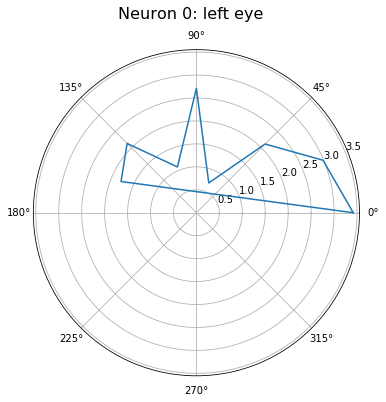

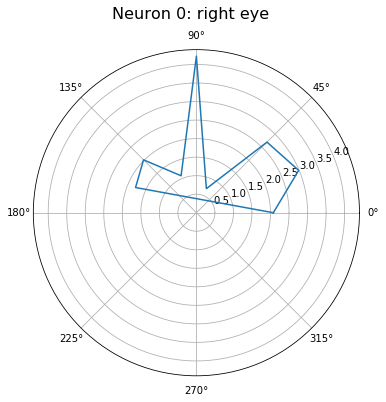

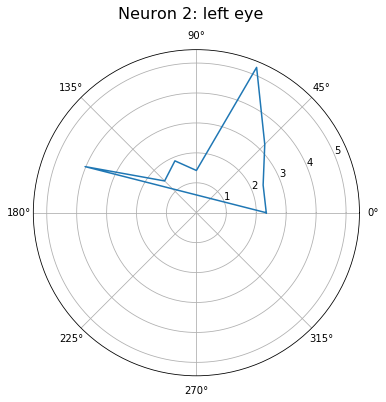

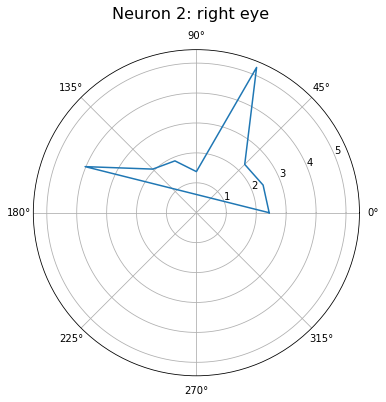

In [11]:

ax1 = makePolarPlot(0,"left")
ax2 = makePolarPlot(0,"right")

fig1 = makePolarPlot(2,"left")
fig2 = makePolarPlot(2,"right")

### Plot 3: Bar plots of mean response of each neuron to each stim
---
- **x-axis**: Stim ID
- **y-axis**: Mean response of this neuron over a window corresponding to the stimulus, taking into account the hard-coded (5 frame) offset 
<br><br>
- **Black dotted line**: mean baseline response of this neuron, i.e. mean response to windows we call "off" (taking into consideration -10 to -1 frames before stim turned on)
- **Green dotted line**: mean baseline + 1 SD
- **Blue dotted line**: mean baseline + 2 SD


**Takeaways**
- Seems like the baseline is a little high given the lowest responses to stim. Baseline will always be bias upward but we should investigate why it is so high. 

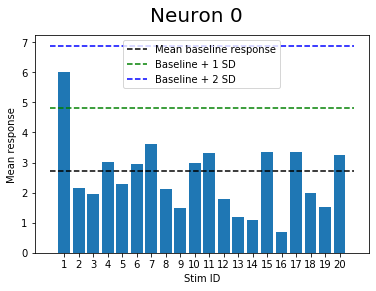

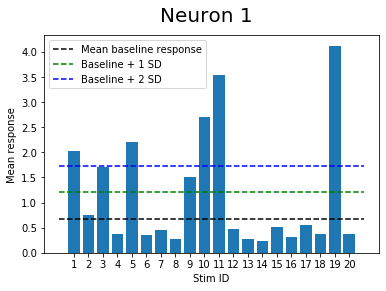

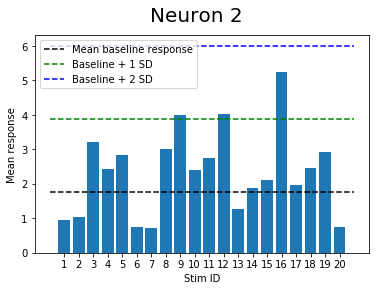

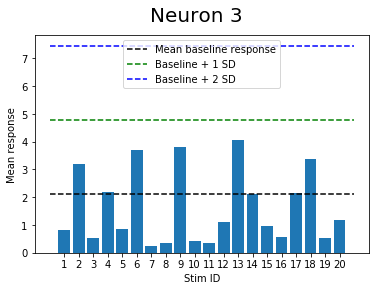

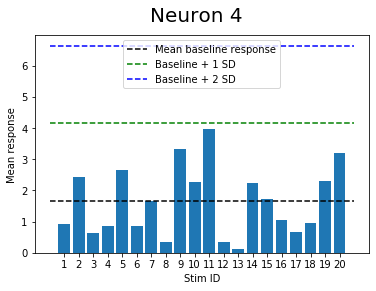

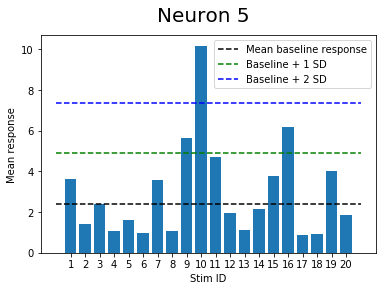

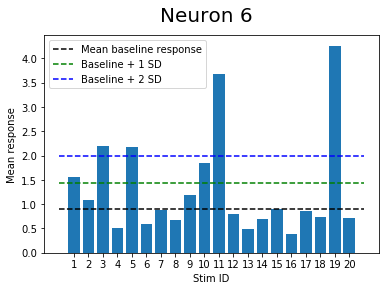

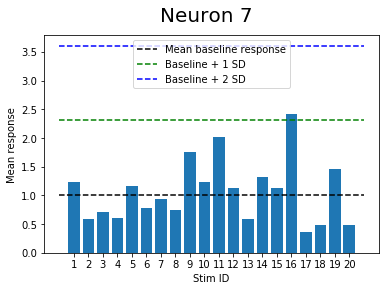

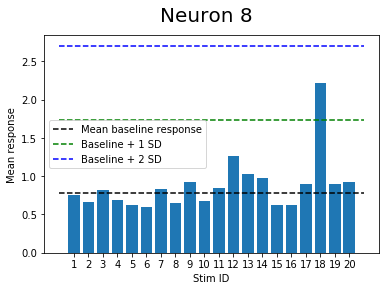

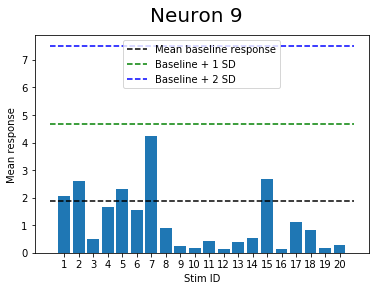

In [12]:

%matplotlib inline

# Plot mean responses of a single neuron to each stim on one plot

for n in range(10): # See first 5 neurons
    fig, ax = plt.subplots()
    fig.suptitle("Neuron {}".format(n), fontsize=20)
    plotNum = 0
    allMeans = np.zeros(num_stim + 1)
    stims = np.arange(1,num_stim + 1)
    for stimId in range(0,num_stim+1):
        stimType = getStimType(stimId)
        responses = np.array(estsByStim[n][stimId])
        meanResponse = np.mean(responses)
        allMeans[stimId] = meanResponse
    ax.bar(stims,allMeans[1:],tick_label=stims)
    
    # Replace baseline of mean to activity during windows where no stimulus is on
    
    # Mean dotted line:
    # overallMean = np.mean(allMeans[1:]) # can do this because we have the same number of data points for each stim
    # ax.plot([0, 21], [overallMean, overallMean], "b--") # Dotted line at overall mean for this neuron
    # ax.legend(['Mean response to any visual stimulus',"Mean baseline response"])


    # Plot baseline dotted line:
    offResponse = np.array(estsByStim[n][0])
    offMean = np.mean(offResponse)
    ax.plot([0,21], [offMean, offMean], "k--")
    
    # Add + 1SD, + 2SD of baseline response lines
    offSD = np.std(offResponse)
    ax.plot([0,21], [offMean + offSD, offMean + offSD], "g--")
    ax.plot([0,21], [offMean + 2*offSD, offMean + 2*offSD], "b--")

    ax.legend(["Mean baseline response",  "Baseline + 1 SD", "Baseline + 2 SD" ])
    ax.set_ylabel("Mean response")
    ax.set_xlabel("Stim ID")

In [13]:
baselineMeans = np.zeros(num_neurons)
baselineSDs = np.zeros(num_neurons)

%matplotlib inline

for n in range(num_neurons):
    offResponse = np.array(estsByStim[n][0])
    baselineMeans[n] = np.mean(offResponse)
    baselineSDs[n] = np.std(offResponse)

meanBaseline = np.mean(baselineMeans)
meanBaselineSD = np.mean(baselineSDs)
baselineSD = np.std(baselineMeans)

print("Mean baseline response:{:.3f}\n".format(meanBaseline))
print("Standard deviation of baselines:{:.3f}\n".format(meanBaselineSD))
print("Standard deviation of standard deviations of neurons' baselines:{:.3f}\n".format(baselineSD))



Mean baseline response:0.607

Standard deviation of baselines:0.850

Standard deviation of standard deviations of neurons' baselines:0.587



Text(0, 0.5, 'Number of neurons')

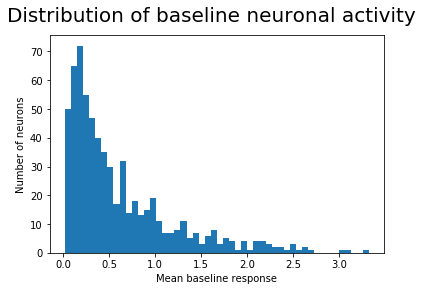

In [14]:
# Plot distribution of all neurons' "baselines"
%matplotlib inline
fig, ax = plt.subplots()
fig.suptitle("Distribution of baseline neuronal activity", fontsize=20)
ax.hist(baselineMeans, bins = 50)
ax.set_xlabel("Mean baseline response")
ax.set_ylabel("Number of neurons")



(639, 161)


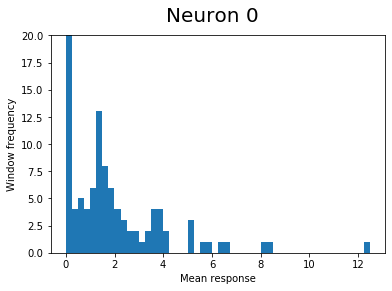

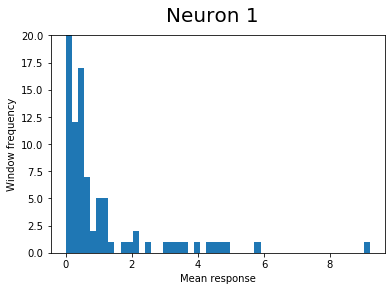

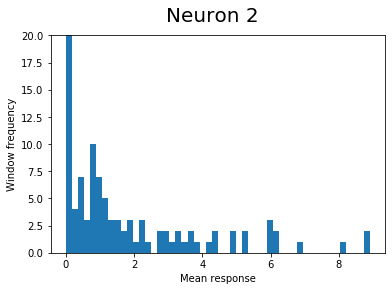

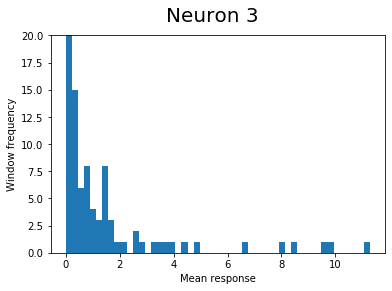

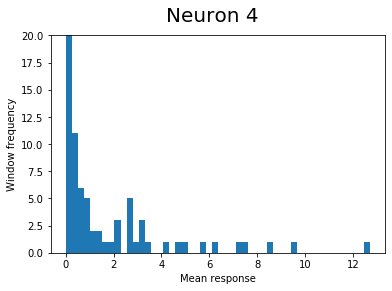

In [15]:

%matplotlib inline

# plot hist of all windows for a single neuron

print(np.shape(stimWindowAvg))
for n in range(5): # See first 5 neurons
    fig, ax = plt.subplots()
    fig.suptitle("Neuron {}".format(n), fontsize=20)
    plotNum = 0
    ax.hist(stimWindowAvg[n,:], bins = 50)
    ax.set_xlabel("Mean response")
    ax.set_ylabel("Window frequency")
    plt.ylim(0, 20)

    

CaImAn does initialization with first few neurons, which makes sense that neuron 0 below looks how it does – a much more curvy peak with less exponential-like decay to frames with high responses


(639, 161)


/Users/nicolemoiseyev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


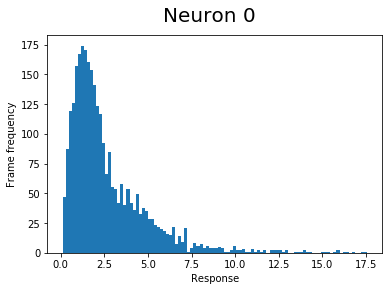

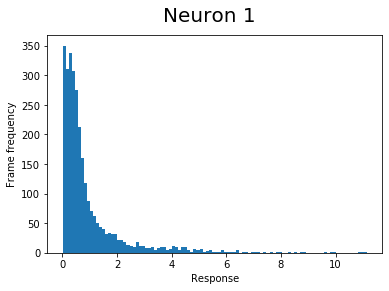

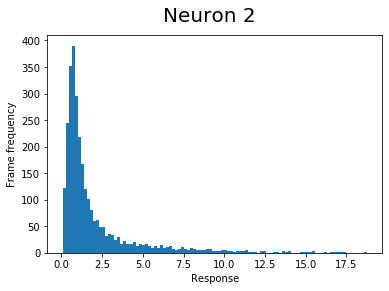

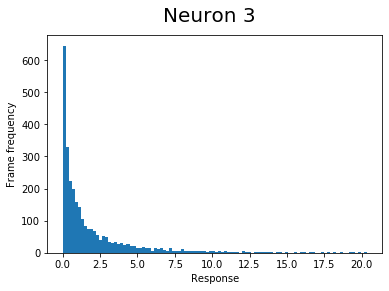

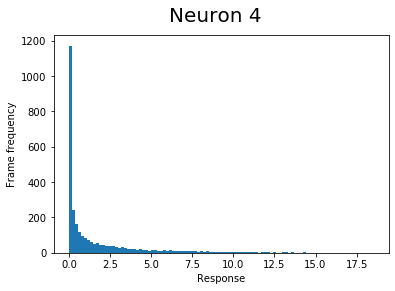

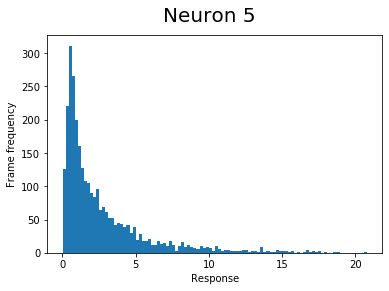

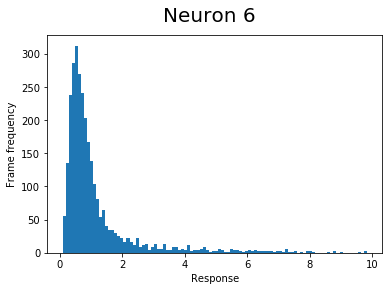

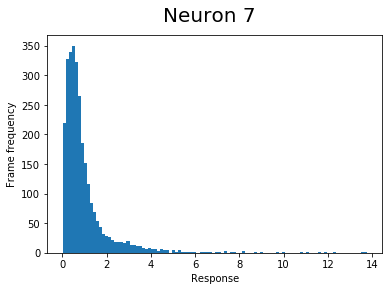

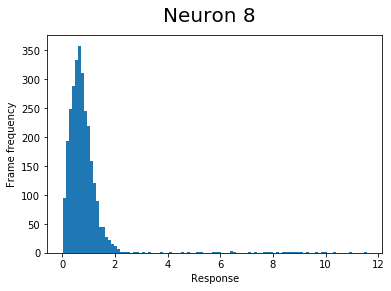

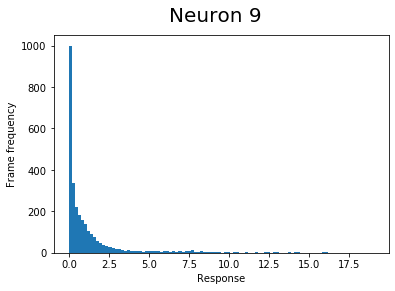

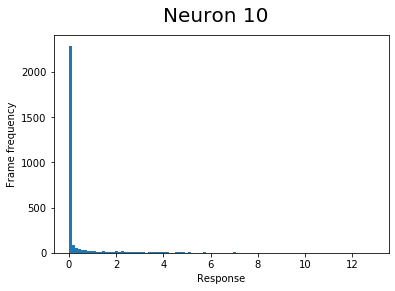

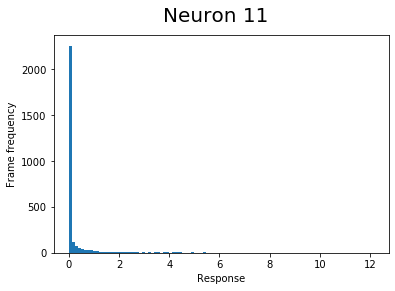

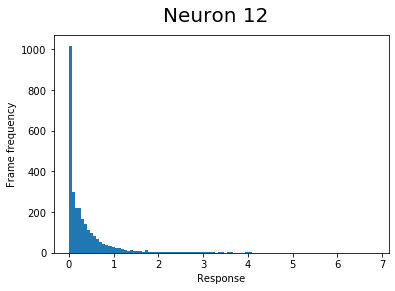

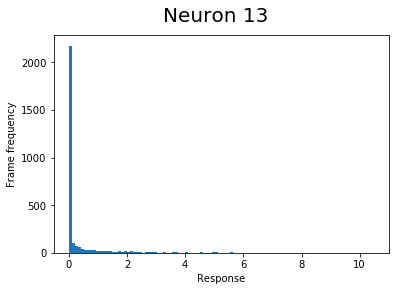

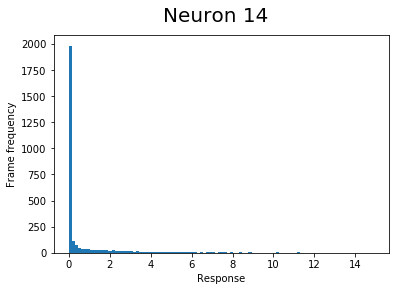

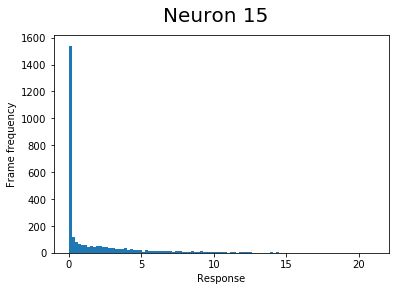

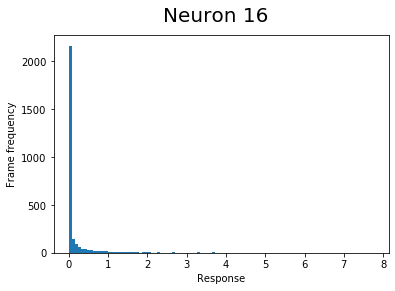

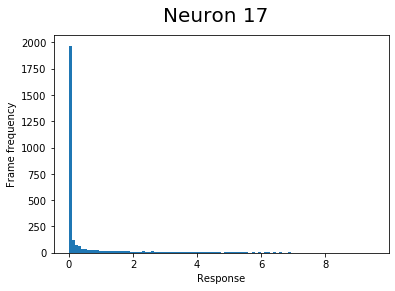

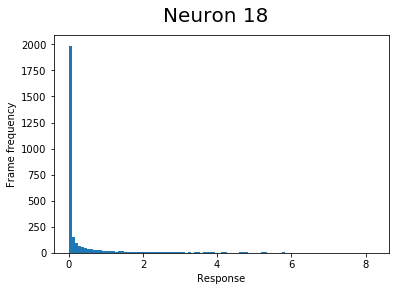

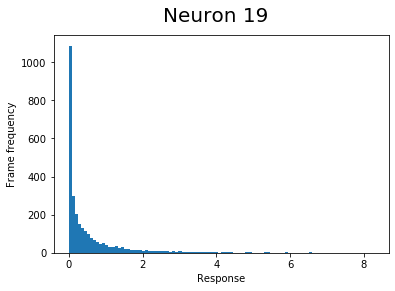

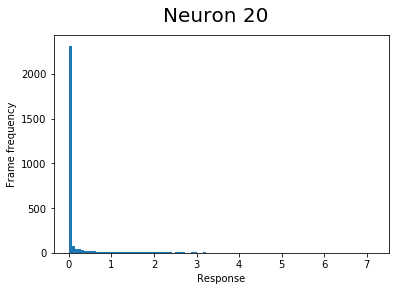

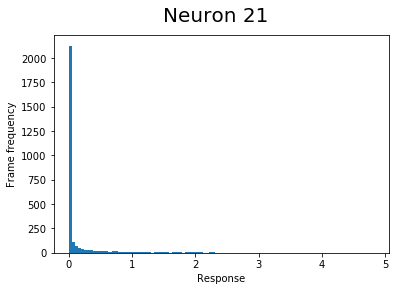

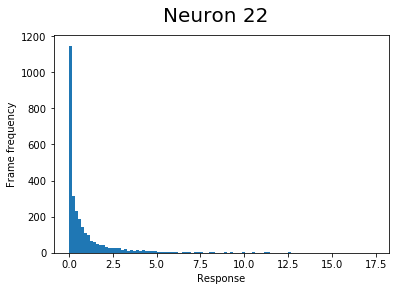

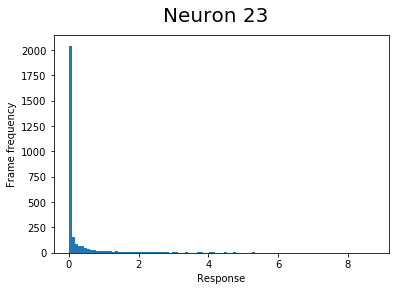

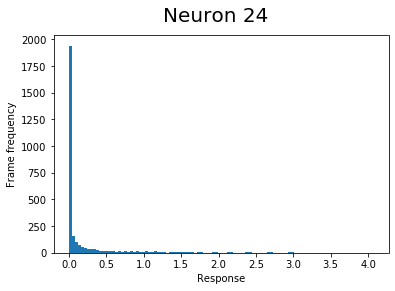

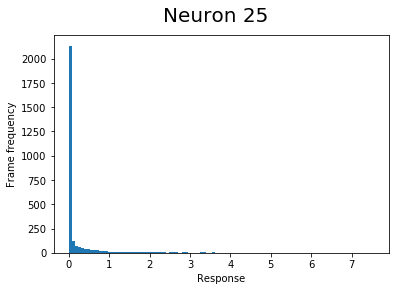

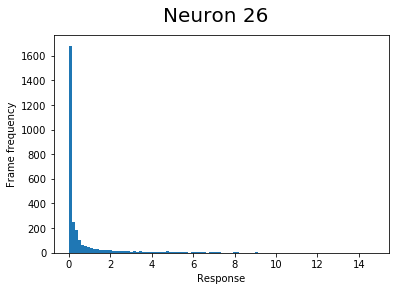

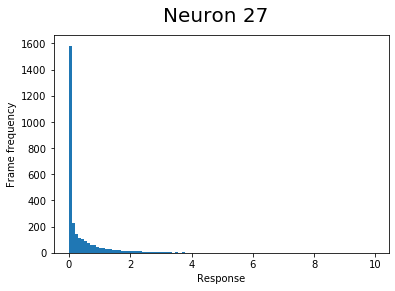

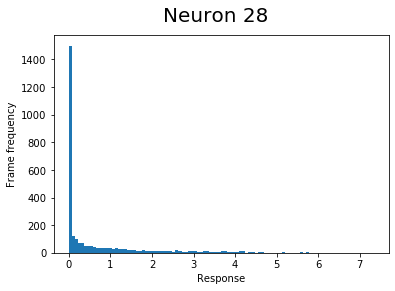

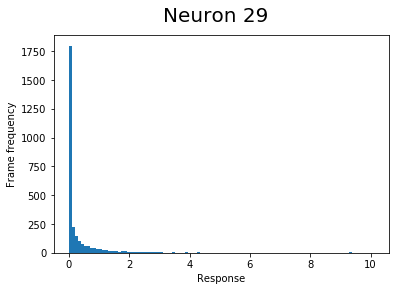

In [16]:

%matplotlib inline

# plot hist of all frames for a single neuron

print(np.shape(stimWindowAvg))
for n in range(30): # See first 5 neurons
    fig, ax = plt.subplots()
    fig.suptitle("Neuron {}".format(n), fontsize=20)
    plotNum = 0
    ax.hist(ests[n,:], bins = 100)
    ax.set_xlabel("Response")
    ax.set_ylabel("Frame frequency")


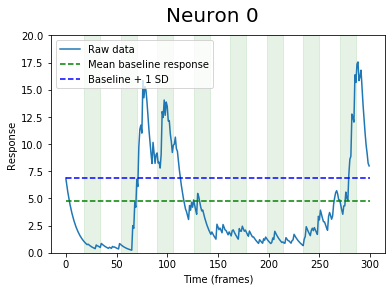

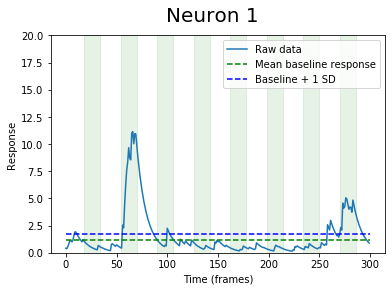

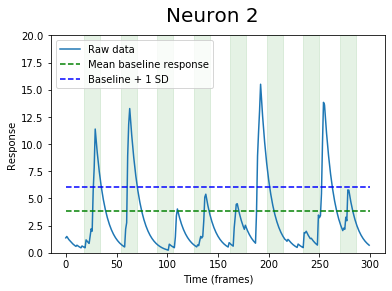

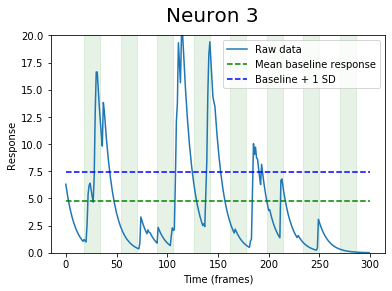

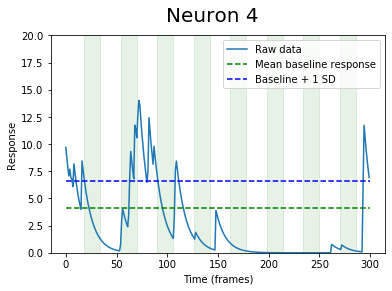

In [17]:


def plotRawResponse(neuron, start = 0, end = 100):
    fig, ax = plt.subplots()
    fig.suptitle("Neuron {}".format(n), fontsize=20)
    onLines = framesStimOn[framesStimOn >= start][framesStimOn < end]
    offLines = framesStimOff[framesStimOff >= start][framesStimOff < end]
    ax.plot(ests[n,start:end])
    ax.set_ylabel("Response")
    ax.set_xlabel("Time (frames)")
    plt.ylim(0, 20)
    offSD = baselineSDs[n]
    offMean = baselineMeans[n]
    ax.plot([start,end], [offMean + offSD, offMean + offSD], "g--")
    ax.plot([start,end], [offMean + 2*offSD, offMean + 2*offSD], "b--")
    #ax.vlines(onLines, 0, 1, transform=ax.get_xaxis_transform(), colors='purple')
    #ax.vlines(offLines, 0, 1, transform=ax.get_xaxis_transform(), colors='black')
    
    for i in range(onLines.size):
        on = onLines[i]
        try:
            off = offLines[i]
        except IndexError:
            off = end
        ax.axvspan(on, off, 0, 1, transform=ax.get_xaxis_transform(), alpha = 0.1, color='green')
    ax.legend(["Raw data", "Mean baseline response",  "Baseline + 1 SD" ])
    
for n in range(5): # See first 5 neurons
    plotRawResponse(n,0,300)

# Plot vertical lines when stim turned on
# Zoom in on smaller windows
# Investigate high baseline mean (NaN out baseline frames)

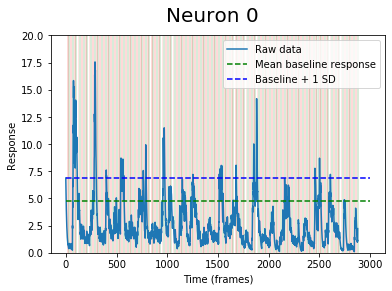

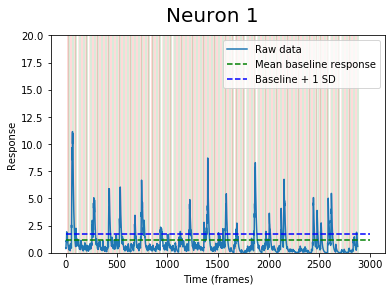

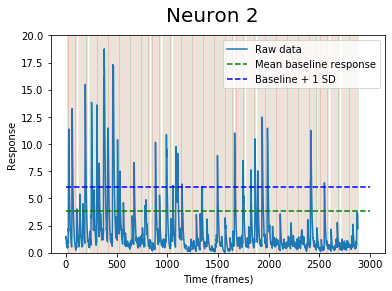

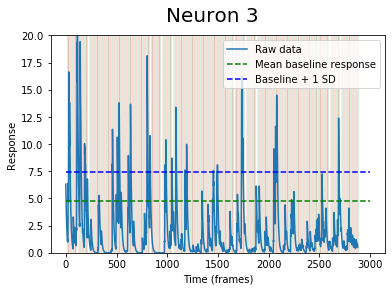

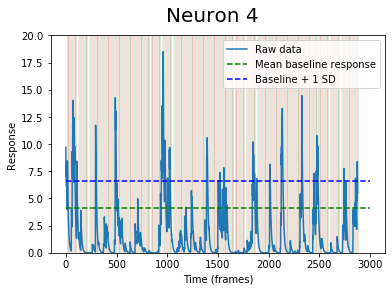

In [18]:
# WINDOWS THAT WE DEFINE

# according to values hardcoded in improv right now

# windows offset by k = 5, using only start times (still 10 frames long)
# green = what we call on
# red = what we call off

def plotRawResponse(neuron, start = 0, end = 100):
    fig, ax = plt.subplots()
    fig.suptitle("Neuron {}".format(n), fontsize=20)
    onLines = framesStimOn[framesStimOn >= start][framesStimOn < end]
    ax.plot(ests[n,start:end])
    ax.set_ylabel("Response")
    ax.set_xlabel("Time (frames)")
    plt.ylim(0, 20)
    offSD = baselineSDs[n]
    offMean = baselineMeans[n]
    ax.plot([start,end], [offMean + offSD, offMean + offSD], "g--")
    ax.plot([start,end], [offMean + 2*offSD, offMean + 2*offSD], "b--")
    #ax.vlines(onLines, 0, 1, transform=ax.get_xaxis_transform(), colors='purple')
    #ax.vlines(offLines, 0, 1, transform=ax.get_xaxis_transform(), colors='black')
    
    for i in range(onLines.size):
        on = onLines[i]
       
        ax.axvspan(on+5, on+15, 0, 1, transform=ax.get_xaxis_transform(), alpha = 0.1, color='green')
        ax.axvspan(on-10, on-1, 0, 1, transform=ax.get_xaxis_transform(), alpha = 0.1, color='red')
    ax.legend(["Raw data", "Mean baseline response",  "Baseline + 1 SD" ])


for n in range(5): # See first 5 neurons
    plotRawResponse(n,0,3000)

In [22]:
def makeOffsetWindows(k):
    stimWindowAvg = np.zeros((num_neurons, num_windows)) # rows: neurons, cols: avgs for window with id = col index

    """ 
    key: neuron, value: dictionary -> 
       (key: stim, value: avgs for that stim for this neuron)
    """ 
    estsByStim = {} 
    for n in range(num_neurons):
        estsByStim[n] = {}
        for stimId in range(0,num_stim+1):
            estsByStim[n][stimId] = []

    """
    Loop over each stim and its corresponding "on" windows 
    (not in chronological order of windows)
    """ 
    windowId = 0
    for stimId in range(0,num_stim+1): # Loop over all stim (which have id 0-20 when including off windows)
        for start in stimStart[stimId]:
            # Create window offset by k frames from stim start
            onInd = np.arange(start+k,start+k+10) # Hard code window length as 10 frames
            onInd = onInd[onInd<num_frames]
            onEst = np.mean(ests[:,onInd], axis=1)
            stimWindowAvg[:,windowId] = onEst  
            for neuron in range(onEst.shape[0]):
                estsByStim[neuron][stimId].append(onEst[neuron])
            windowId += 1
    
    return estsByStim

In [23]:
from ipywidgets import *

def update(k=0):
    for n in range(10,11):
        fig, ax = plt.subplots()
        fig.suptitle("Neuron {}".format(n), fontsize=20)
        kWindowEsts = makeOffsetWindows(k)
        plotNum = 0
        allMeans = np.zeros(num_stim + 1)
        stims = np.arange(1,num_stim + 1)
        for stimId in range(0,num_stim+1):
            stimType = getStimType(stimId)
            responses = np.array(kWindowEsts[n][stimId])
            meanResponse = np.mean(responses)
            allMeans[stimId] = meanResponse
            ax.bar(stims,allMeans[1:],tick_label=stims)
            
        # Stim off dotted line:
        offResponse = np.array(kWindowEsts[n][0])
        offMean = np.mean(offResponse)
        ax.plot([0,21], [offMean, offMean], "k--")
        

        # Add + 2SD of baseline response lines
        offSD = np.std(offResponse)
        ax.plot([0,21], [offMean + offSD, offMean + offSD], "g--")
        ax.plot([0,21], [offMean + 2*offSD, offMean + 2*offSD], "b--")

        ax.legend(["Mean baseline response",  "Baseline + 1 SD", "Baseline + 2 SD" ])
        ax.set_ylabel("Mean response")
        ax.set_xlabel("Stim ID")
        
        print("Neuron ", n, "\n------------\n")
        print("Off SD:\n{}\n".format(offSD))
        print("Off mean:\n{}\n".format(offMean))
        print("Number of stims 1 SD above baseline:\n{}\n".format(allMeans[allMeans > offMean + offSD].size))
        print("Number of stims 2 SD above baseline:\n{}\n".format(allMeans[allMeans > offMean + 2*offSD].size))



interact(update, k = widgets.IntSlider(value=0, min=0, max=20, step=1, continuous_update=False))


# Why delta F / F (display purposes vs analysis)
# Investigate other normalizations that Eva does


interactive(children=(IntSlider(value=0, continuous_update=False, description='k', max=20), Output()), _dom_cl…

<function __main__.update(k=0)>